# Importing Dependencies

## Downloading packages in Google Colab environment

In [1]:
!python -m pip install --upgrade --force-reinstall numpy-quaternion
!pip install apriltag

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 19.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Creat

In [4]:
import math
import numpy as np
import quaternion
import matplotlib.pyplot as plt
import cv2 as cv
import glob
import apriltag
from google.colab.patches import cv2_imshow

In [8]:
vicon = np.genfromtxt('/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/Camera_Vicon_qtrn.csv', delimiter=',')
vicon = np.delete(vicon, [0,1], 0)
vicon.shape

(15710, 9)

In [9]:
file = '/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/cam0/undistorted_png/*.png' 
#glob.glob(file)
# Using List Comprehension to read all images
images = [cv.imread(image) for image in glob.glob(file)]

## AprilTag visibility check

In [10]:
def getCornerPos(gray):
  '''
  Returns detected tags in the image. If no tags are detected, then returns None
  INPUT: Gray image
  OUTPUT: Detected tag ids, corresponding corners in image coordinates
  '''
  options = apriltag.DetectorOptions(families="tag16h5")
  detector = apriltag.Detector(options)
  results = detector.detect(gray)
  if results == []:
    return None, None

  detected_tags = []
  corresponding_corners = []
  for i in range(len(results)):
    c = results[i].corners.astype(np.int32)
    d = math.dist(c[0, :], c[2, :])
    if results[i].tag_id <= 11: #and (d >= 100):
      detected_tags.append(results[i].tag_id)
      corresponding_corners.append(c)
  
  if detected_tags == []:
    return None, None

  return detected_tags, corresponding_corners

for j in range(len(images)):
  img = images[j]
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  tags, crnr = getCornerPos(img)
  if tags == None:
    print("No Tags detected in frame:", j)
  else:
    crnr = np.array(crnr)
    cv.polylines(img, crnr, True, (0, 0, 255), thickness = 2)

## Constants and Functions

In [11]:
# CAMERA INTRINSICS MATRIX
fx = 400
fy = 400
cx = 424.5
cy = 400.5
K = np.array([[fx, 0, cx],
            [0, fy, cy],
            [0, 0, 1]])

def skew_sym(v):
    if v.size != 3:
        raise ValueError('Input vector must have three elements')
    
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def RP_from_Homography(Hmg):
  H = np.linalg.inv(K) @ Hmg

  R_cw = np.zeros_like(H)
  R_cw[:, 0] = H[:, 0]
  R_cw[:, 1] = H[:, 1]
  R_cw[:, 2] = skew_sym(H[:, 0]) @ H[:, 1]

  U, S, V_T = np.linalg.svd(R_cw)
  S1 = np.array([[1, 0, 0], [0, 1, 0],[0, 0, np.linalg.det(U @ V_T)]])

  R_cw = U @ S1 @ V_T

  t_cw_in_c = H[:, 2]/np.linalg.norm(H[:, 0])

  return R_cw, t_cw_in_c

def RP2T(R: np.array, p: np.array):
  T = np.append(R, p.reshape(3,1), axis=1)
  T = np.append(T, np.array([[0,0,0,1]]), axis=0)
  return T

def rotm2eulZYX(R):
    theta_y = np.arctan2(R[0, 2], np.sqrt(R[0, 0]**2 + R[0, 1]**2))
    theta_x = np.arctan2(-R[1, 2], R[2, 2])
    theta_z = np.arctan2(R[1, 0], R[1, 1])

    return np.array([theta_x, theta_y, theta_z])

def eul2rotmZYX(angles):
  x = angles[0]
  y = angles[1]
  z = angles[2]
  return rotz(z) @ roty(y) @ rotx(x)

def rotx(x):
  return np.array([[1, 0, 0],
                [0, np.cos(x), -np.sin(x)],
                [0, np.sin(x), np.cos(x)]])

def roty(y):
  return np.array([[np.cos(y), 0, np.sin(y)],
                [0, 1, 0],
                [-np.sin(y), 0, np.cos(y)]])

def rotz(z):
  return np.array([[np.cos(z), -np.sin(z), 0],
                [np.sin(z), np.cos(z), 0],
                [0, 0, 1]])

# Vicon data

## Transforming vicon data in appropriate frame

In [12]:
# Notations
# w --> world frame in VICON
# v --> vicon frame
# body --> body frame

# Constant transformation T_v2c
R_v2c = rotz(np.pi) @ roty(0) @ rotx(-np.pi/2)
p_v2c = np.zeros(3)
T_v2c = RP2T(R_v2c, p_v2c)

# Constant transformation T_w2v
q = vicon[0, 2:6]
q = np.quaternion(q[3], q[0], q[1], q[2])
R_w2v = quaternion.as_rotation_matrix(q)
p_w2v_in_w = vicon[0, 6:]
T_w2v = RP2T(R_w2v, p_w2v_in_w)


# Initialize
vicon_in_viconframe = np.zeros((len(vicon), 7))
for i in range(len(vicon)):
  # Rotm
  q = vicon[i, 2:6]
  q_w2body = np.quaternion(q[3], q[0], q[1], q[2])
  R_w2body = quaternion.as_rotation_matrix(q_w2body)

  # Position
  p_w2body_in_w = vicon[i, 6:]

  # Combining
  T_w2body = RP2T(R_w2body, p_w2body_in_w)

  # Transformation
  T_v2body = np.linalg.inv(T_w2v) @ T_w2body

  # Extract R|p
  R_v2body = T_v2body[:3, :3]
  p_v2body_in_v = T_v2body[:3, 3]
  
  # Extract q from R
  q_v2body = rotm2eulZYX(R_v2body)

  vicon_in_viconframe[i, 4:7] = q_v2body
  vicon_in_viconframe[i, 1:4] = 0.001*p_v2body_in_v

# Timestamps
vicon_y = np.zeros((len(vicon_in_viconframe)))
k = 0
for i in range(len(vicon_in_viconframe)):
  vicon_y[i] = k
  k += 1/800

vicon_in_viconframe[:, 0] = vicon_y

# Visual Pose Estimation

## World coordinates of AprilTags

In [13]:
world_tags = {0:np.array([[0, 34.925], [34.925, 34.925], [34.925, 0], [0, 0]]),
              1:np.array([[52.3875, 34.925], [52.3875+34.925, 34.925], [52.3875+34.925, 0], [52.3875, 0]]),
              2:np.array([[52.3875*2, 34.925], [52.3875*2+34.925, 34.925], [52.3875*2+34.925, 0], [52.3875*2, 0]]),
              3:np.array([[52.3875*3, 34.925], [52.3875*3+34.925, 34.925], [52.3875*3+34.925, 0], [52.3875*3, 0]]),
              4:np.array([[0, 52.3875+34.925], [34.925, 52.3875+34.925], [34.925, 52.3875], [0, 52.3875]]),
              5:np.array([[52.3875, 52.3875+34.925], [52.3875+34.925, 52.3875+34.925], [52.3875+34.925, 52.3875], [52.3875, 52.3875]]),
              6:np.array([[52.3875*2, 52.3875+34.925], [52.3875*2+34.925, 52.3875+34.925], [52.3875*2+34.925, 52.3875], [52.3875*2, 52.3875]]),
              7:np.array([[52.3875*3, 52.3875+34.925], [52.3875*3+34.925, 52.3875+34.925], [52.3875*3+34.925, 52.3875], [52.3875*3, 52.3875]]),
              8:np.array([[0, 52.3875*2+34.925], [34.925, 52.3875*2+34.925], [34.925, 52.3875*2], [0, 52.3875*2]]),
              9:np.array([[52.3875, 52.3875*2+34.925], [52.3875+34.925, 52.3875*2+34.925], [52.3875+34.925, 52.3875*2], [52.3875, 52.3875*2]]),
              10:np.array([[52.3875*2, 52.3875*2+34.925], [52.3875*2+34.925, 52.3875*2+34.925], [52.3875*2+34.925, 52.3875*2], [52.3875*2, 52.3875*2]]),
              11:np.array([[52.3875*3, 52.3875*2+34.925], [52.3875*3+34.925, 52.3875*2+34.925], [52.3875*3+34.925, 52.3875*2], [52.3875*3, 52.3875*2]])}

## Main

In [14]:
# Notations
# b : body frame
# c : camera (first instance of body frame)
# w : world (apriltag) frame

# Constant transformation T_v2c
R_v2c = rotz(np.pi) @ roty(0) @ rotx(-np.pi/2)

t = [];
e = [];
T_bw_list = [];
for n in range(0, len(images), 1):
  img = images[n]
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  tags, corners = getCornerPos(gray)
  src = np.zeros((4*len(tags), 2))
  des = np.zeros_like(src)
  for i, id in enumerate(tags):
    world_corners = world_tags[id]
    image_corners = corners[i]
    for r in range(4):
      src[4*i+r, :] = world_corners[r, :]
      des[4*i+r, :] = image_corners[r, :]
    
  Hmg, mask = cv.findHomography(src, des, cv.RANSAC)

  R_bw, t_bw_in_b = RP_from_Homography(Hmg)

  # Transforming to correct frames (IB)
  T_bw = RP2T(R_bw, t_bw_in_b)

  T_bw_list.append(T_bw)

  if n==0:
    T_cw = T_bw

  T_cb = T_cw @ np.linalg.inv(T_bw)
  #T_cb = np.linalg.inv(T_v2c) @ T_cb

  #eul = get_euler_from_rotm(T_cb[:3, :3])
  eul = rotm2eulZYX(T_cb[:3, :3])

  # Aligning axes with vicon frame
  eul[0] = -eul[0]
  temp = eul[1]
  eul[1] = -eul[2]
  eul[2] = -temp


  e.append(eul)

  t.append(0.001*np.linalg.inv(R_v2c) @ T_cb[:3, 3])

t = np.array(t)
e = np.array(e)

pq = np.hstack((t, e))

# Attaching timestamps
timestamps = np.genfromtxt('/content/drive/MyDrive/VO_T265/TEST_WITH_VICON/cam0/data.csv', delimiter=',')
timestamps = (timestamps[:, 0].reshape(len(timestamps), 1) - timestamps[0, 0]) * 1e-9
pq = np.hstack((timestamps, pq))

# Visual Odometry vs Ground Truth

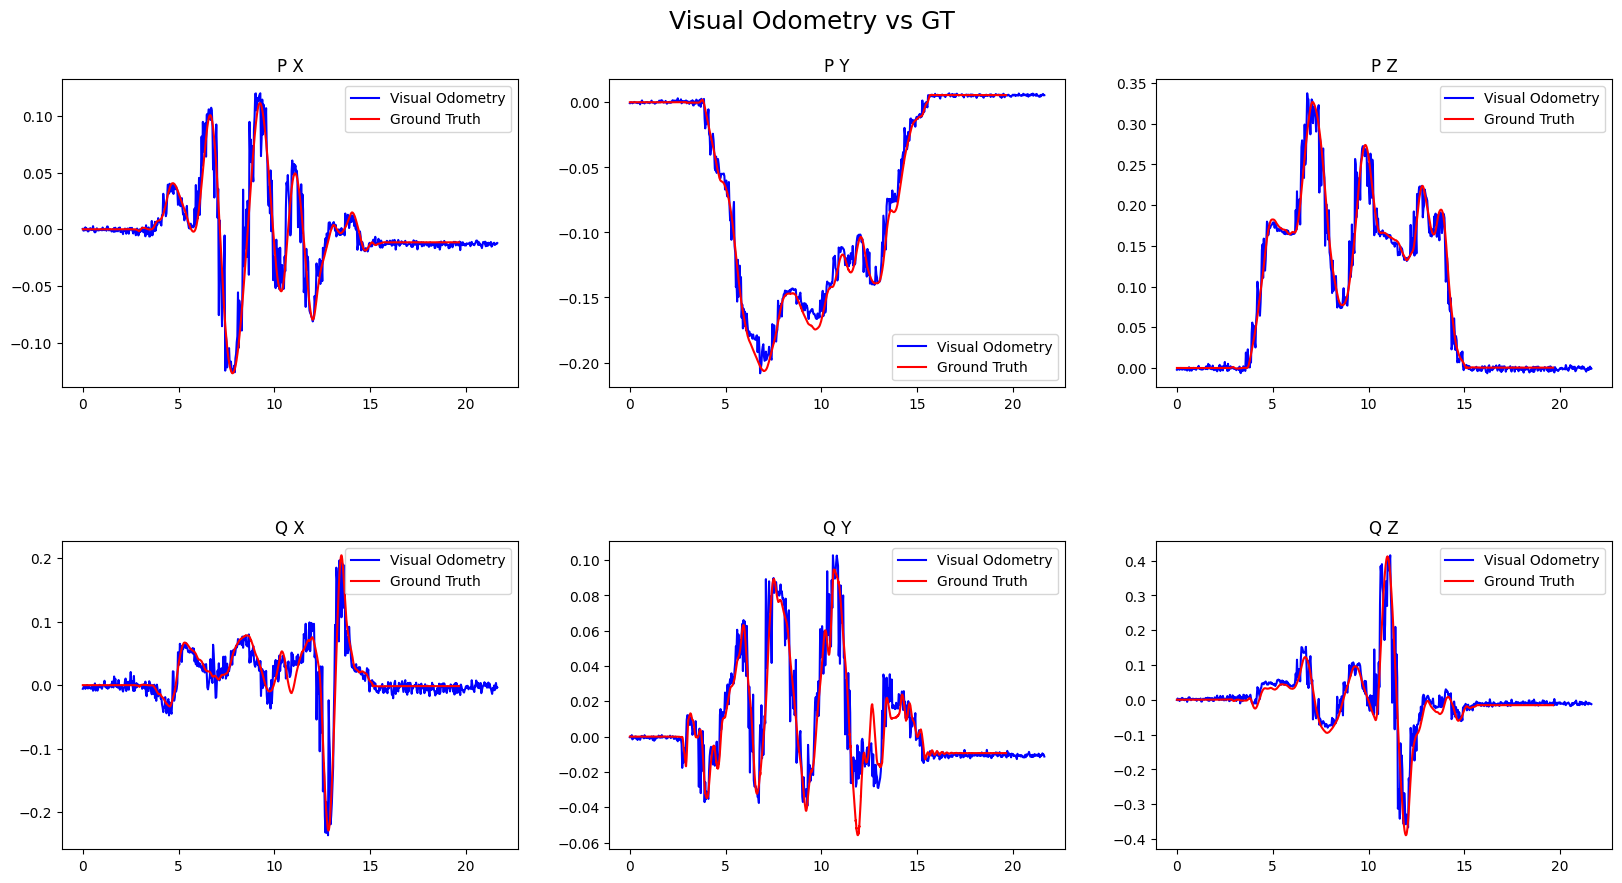

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Visual Odometry vs GT", fontsize=18, y=0.95)
tickers = ["P X", "P Y", "P Z", "q X", "q Y", "q Z"]
i = 1

for ticker, ax in zip(tickers, axs.ravel()):

    ax.plot(pq[:-96, 0], pq[96:, i], 'b', label = 'Visual Odometry')           #96 is a factor used to align both sets of data according to time.
    ax.plot(vicon_in_viconframe[:, 0], vicon_in_viconframe[:, i], 'r', label = 'Ground Truth')

    # chart formatting
    ax.legend(loc = 'best')
    ax.set_title(ticker.upper())
    ax.set_xlabel("")

    i+=1

plt.show()